In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import shap
import xgboost as xgb
from sklearn.metrics import r2_score as r2_score_function
from matplotlib.lines import Line2D


In [3]:
data = pd.read_csv('DataTrainValidation.csv')
data['theta12'] = data['theta1'] + data['theta2']
data = data.drop(['theta1', 'theta2'], axis=1)
X = pd.concat([data.iloc[:, 1:-2], data.iloc[:, -1:]], axis=1)
Y = data.iloc[:,-2]
X

,Mean_Cu-O,Mean_Cu-N,Mean_O-Cu-O,Mean_N-Cu-N,theta12
0,577.365,529.933,312.619,287.445,191.481
1,573.684,526.929,275.663,245.595,192.903
2,574.144,532.502,289.075,301.632,190.301
3,583.671,519.973,335.416,289.010,192.494
4,566.869,496.398,299.624,270.938,194.407
...,...,...,...,...,...
103,583.319,503.472,304.435,362.135,183.080
104,592.000,496.050,310.579,350.796,182.800
105,629.034,519.737,424.327,329.601,190.150
106,628.584,506.082,435.644,301.641,193.540


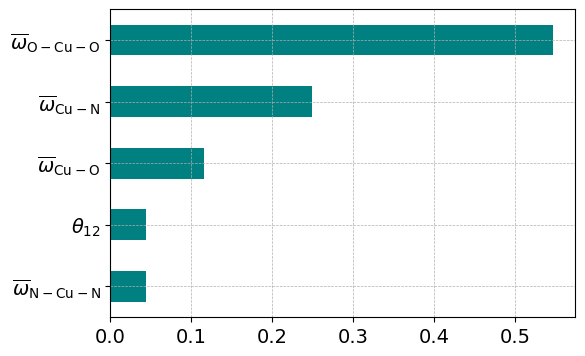

In [4]:
# xgb_model = xgb.XGBRegressor(objective="reg:squarederror")
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    max_depth=4,
    eta=0.3,
    eval_metric="rmse"
)
xgb_model.fit(X, Y)

feature_importances_xgb = xgb_model.feature_importances_
importances_xgb = pd.Series(feature_importances_xgb, index=X.columns)
importances_sorted_xgb = importances_xgb.sort_values()

# Plot
plt.figure(figsize=(6, 4))
plt.grid()
ax =importances_sorted_xgb.plot(kind='barh', color='teal')

# Define new labels
new_labels = [
    r'$\overline{\omega}_{\mathrm{N-Cu-N}}$',
    r'$\theta_{12}$',
    r'$\overline{\omega}_{\mathrm{Cu-O}}$',
    r'$\overline{\omega}_{\mathrm{Cu-N}}$',
    r'$\overline{\omega}_{\mathrm{O-Cu-O}}$'
]

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Apply new labels
ax.set_yticklabels(new_labels, fontsize=14, fontweight='bold')
plt.xticks(fontsize=14)

plt.savefig('xgb_feature.png', dpi=500, bbox_inches='tight', format='png')  # Specify EPS format
plt.show()

In [5]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Similarly, ensure that other functions like rmse_std, mae, and r2 are defined correctly and not overwritten
def rmse_std(y_true, y_pred):
    return rmse(y_true, y_pred) / np.std(y_true)

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def parity_plot(y_true, y_predictions, title, filename):
    plt.figure(figsize=(6, 6))
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5)
    plt.xlim(40, 160)
    plt.ylim(40, 160)
    
    colorscheme = ['red' if abs(true - pred) > 5 else 'darkgreen' for true, pred in zip(y_true, y_predictions)]
    plt.scatter(y_true, y_predictions, c=colorscheme, alpha=0.9, linewidths=2, marker ="o")
    
    plt.plot([40, 160], [40, 160], 'k--', lw=2)
    plt.fill_between([40, 160], [50, 170], [30, 150], color='grey', alpha=0.1)
    plt.xlabel(r'$\Delta E_{DFT}^{\ddag}$', fontsize=16)
    plt.ylabel(r'$\Delta E_{ML}^{\ddag}$', fontsize=16)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    legend_elements = [Line2D([0], [0], color='darkgreen', marker='o', linestyle='', label='Prediction'),
                       Line2D([0], [0], color='black', linestyle='--', lw=2, label='Ideal')]
    plt.legend(handles=legend_elements, frameon=True)

    
    # plt.title(title)
    # plt.legend(["Prediction", "Ideal"], frameon=True)
    
    plt.savefig(filename, dpi=500, bbox_inches='tight')
    plt.show()


def parity_stats_side_by_side(y_left_true,Y_left_predictions,y_right_true,Y_right_predictions,title_left,title_right):
    
    rmse_left = rmse(y_left_true,Y_left_predictions)
    rmse_std_left = rmse_std(y_left_true,Y_left_predictions)
    mae_left = mae(y_left_true,Y_left_predictions)
    r2_left = r2(y_left_true,Y_left_predictions)
    
    rmse_right = rmse(y_right_true,Y_right_predictions)
    rmse_std_right = rmse_std(y_right_true,Y_right_predictions)
    mae_right = mae(y_right_true,Y_right_predictions)
    r2_right = r2(y_right_true,Y_right_predictions)
    
    stats_df = pd.DataFrame({'Error Metric' : ['RMSE', 'RMSE/std', 'MAE', 'R2'], 
                             title_left : [str(rmse_left) + " (kJ/mol)", rmse_std_left, str(mae_left) + " (kJ/mol)", r2_left],
                             title_right: [str(rmse_right) + " (kJ/mol)", rmse_std_right, str(mae_right) + " (kJ/mol)", r2_right],
                             'Note' : ['(0.0 for perfect prediction)', '(0.0 for perfect prediction)','(0.0 for perfect prediction)','(1.0 for perfect prediction)']})
    return stats_df



In [8]:
R2test = []
R2train = []
rmsetest = []
rmsetrain = []

start = 0
end = 2000
test_size = 0.1

# Set XGBoost parameters
params = {
    'max_depth': 4,
    'eta': 0.3,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

for random_state in range(start, end + 1):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    dtrain = xgb.DMatrix(X_train, label=Y_train)
    dtest = xgb.DMatrix(X_test, label=Y_test)

    # Train the XGBoost model
    num_rounds = 100
    bst = xgb.train(params, dtrain, num_rounds)

    # Make predictions
    Y_pred_test = bst.predict(dtest)
    Y_pred_train = bst.predict(dtrain)

    # Calculate R2 and RMSE
    R2_test = r2_score(Y_test, Y_pred_test)
    R2_train = r2_score(Y_train, Y_pred_train)
    rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
    rmse_train = np.sqrt(mean_squared_error(Y_train, Y_pred_train))

    # Append to lists
    R2test.append(R2_test)
    R2train.append(R2_train)
    rmsetest.append(rmse_test)
    rmsetrain.append(rmse_train)

# Analyze results
min_rmse_test = min(rmsetest)
ind = rmsetest.index(min_rmse_test)
avg_rmse_train = np.mean(rmsetrain)
avg_rmse_test = np.mean(rmsetest)
avg_r2_train = np.mean(R2train)
avg_r2_test = np.mean(R2test)

print("Random state with minimum RMSE test is =", start+ind)
print("Best R2 train/test =", R2train[ind], "/", R2test[ind])
print("Best RMSE train/test =", rmsetrain[ind], "/", rmsetest[ind])
print("Avg R2 train/test =", avg_r2_train, "/", avg_r2_test)
print("Avg RMSE train/test =", avg_rmse_train, "/", avg_rmse_test)

Random state with minimum RMSE test is = 1848
Best R2 train/test = 0.9999945856315865 / 0.899676609581538
Best RMSE train/test = 0.04215789361070734 / 3.2504098249957685
Avg R2 train/test = 0.9999934179618631 / 0.6530108717391633
Avg RMSE train/test = 0.04369996966423981 / 8.723266796800466


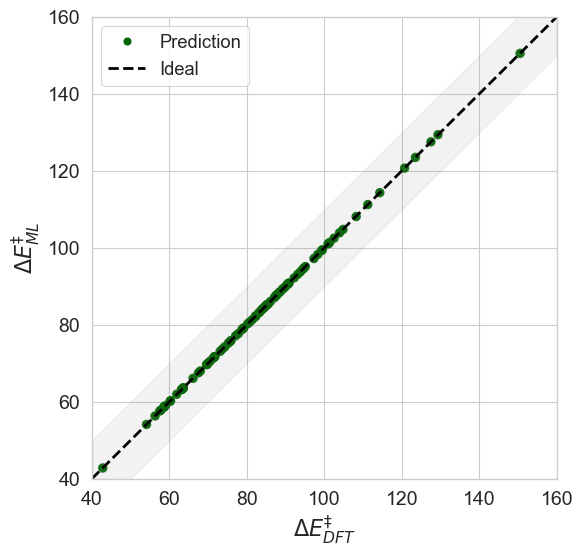

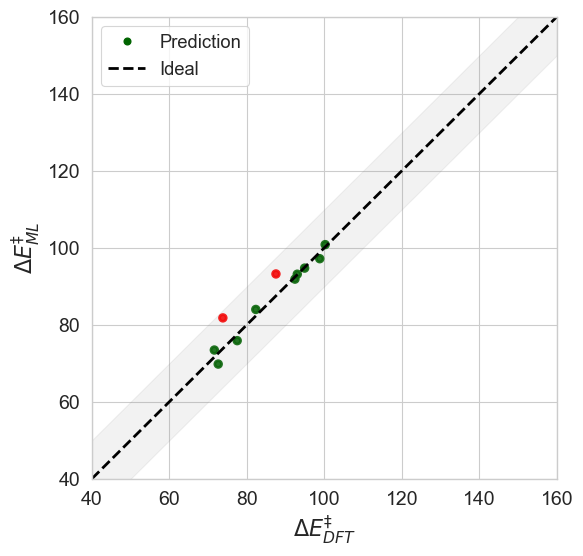

,Error Metric,Training Data,Test Data,Note
0,RMSE,0.04215789361070734 (kJ/mol),3.2504098249957685 (kJ/mol),(0.0 for perfect prediction)
1,RMSE/std,0.002327,0.316739,(0.0 for perfect prediction)
2,MAE,0.030772093153491418 (kJ/mol),2.249363708496095 (kJ/mol),(0.0 for perfect prediction)
3,R2,0.999995,0.899677,(1.0 for perfect prediction)


In [9]:
test_size = 0.1
# scaler = StandardScaler()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=1848)
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Initialize the XGBRegressor model
xgb_model2 = xgb.XGBRegressor(
    objective="reg:squarederror",
    max_depth=4,
    eta=0.3,
    random_state=1848,
    eval_metric="rmse"
)

# Train the model using the scaled training data
xgb_model2.fit(X_train, Y_train)

# Make predictions on the scaled test data
test_predictions = xgb_model2.predict(X_test)

# Optionally, make predictions on the scaled training data for evaluation
train_predictions = xgb_model2.predict(X_train)

# Plot and save training data parity plot
parity_plot(Y_train, train_predictions, "Training Data Parity Plot", "training_parity_plot_xgboost.png")

# Plot and save test data parity plot
parity_plot(Y_test, test_predictions, "Test Data Parity Plot", "test_parity_plot_xgboost.png")

parity_stats_side_by_side(Y_train,train_predictions,Y_test,test_predictions,"Training Data","Test Data")  # print error metrics for training data

# print(Y_test-test_predictions)

Catalyst: 7_och3_no2, DFT: 74.4, Predicted: 73.99258422851562, Difference: -0.4074157714843807
Catalyst: iminch32, DFT: 94.0, Predicted: 87.27738189697266, Difference: -6.722618103027344
Catalyst: 1C_7, DFT: 53.3, Predicted: 56.63990020751953, Difference: 3.339900207519534
Catalyst: 2C_19, DFT: 79.7, Predicted: 71.00379180908203, Difference: -8.696208190917972
Catalyst: DA2_th_th, DFT: 79.7, Predicted: 83.32184600830078, Difference: 3.6218460083007784


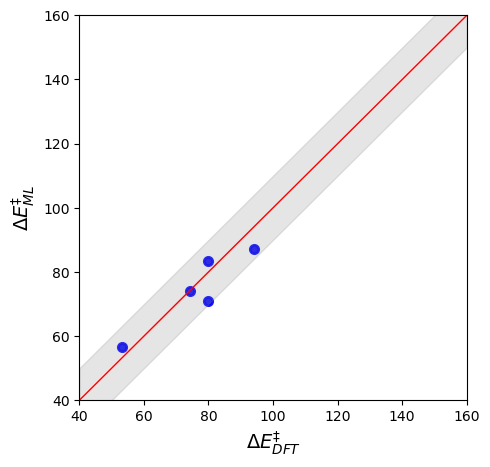

R2: 0.8328442733687608
MAE: 4.557597656250001


In [10]:
df2 = pd.read_csv('DataTest.csv')
df2['theta12'] = df2['theta1'] + df2['theta2']
# Prepare the features for prediction
features_df2 = df2.drop([ 'Folder', 'Barrier', 'theta1', 'theta2'], axis=1)

# Make predictions
predictions_test12 = xgb_model2.predict(features_df2) 

# Calculate differences
differences = predictions_test12 - df2['Barrier']

# Print Folder, Actual, Predicted, and Difference
for folder, actual, predicted, difference in zip(df2['Folder'], df2['Barrier'], predictions_test12, differences):
    print(f"Catalyst: {folder}, DFT: {actual}, Predicted: {predicted}, Difference: {difference}")

# Plotting
plt.style.use('default')
plt.figure(figsize=(5, 5))
plt.scatter(df2['Barrier'], predictions_test12, color='blue', alpha=0.9, linewidths=2, marker ="o")
plt.plot([40, 160], [40, 160], color='red', linestyle='-', linewidth=1, markersize=12)
plt.xlim(40, 160)
plt.ylim(40, 160)
plt.fill_between([40, 160], [50, 170], [30, 150], color='grey', alpha=0.2)
plt.xlabel(r'$\Delta E_{DFT}^{\ddag}$', fontsize=14)
plt.ylabel(r'$\Delta E_{ML}^{\ddag}$', fontsize=14)
plt.show()

# Calculate R2 and MAE
r2 = r2_score(df2['Barrier'], predictions_test12)
mae = mean_absolute_error(df2['Barrier'], predictions_test12)

print('R2:', r2)
print('MAE:', mae)

<Figure size 800x600 with 0 Axes>

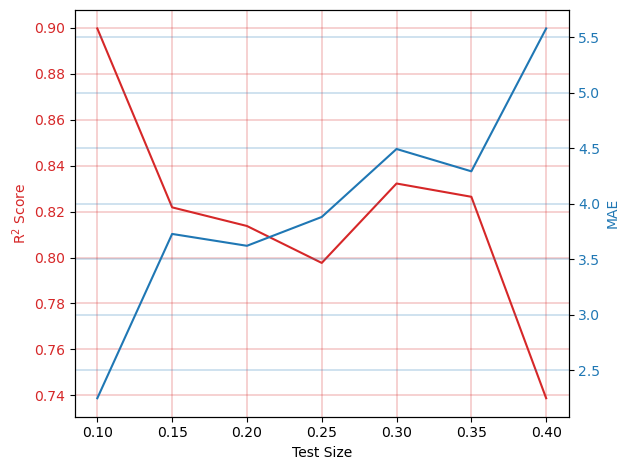

In [11]:
test_sizes = [0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]
r2_scores = []
mae_scores = []

for test_size in test_sizes:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=1848)
    xgb_model3 = xgb.XGBRegressor(
        objective="reg:squarederror",
        max_depth=4,
        eta=0.3,
        eval_metric="rmse"
        )
    
    xgb_model3.fit(X_train, Y_train)
    Test_predictions = xgb_model3.predict(X_test)

    r2 = r2_score(Y_test, Test_predictions)
    mae = mean_absolute_error(Y_test, Test_predictions)

    r2_scores.append(r2)
    mae_scores.append(mae)

# Plotting
plt.figure(figsize=(8, 6))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Test Size')
ax1.set_ylabel('R$^2$ Score', color=color)
ax1.plot(test_sizes, r2_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(color=color, linestyle='-', linewidth=0.3)
# ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('MAE', color=color)  # we already handled the x-label with ax1
ax2.plot(test_sizes, mae_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(color=color, linestyle='-', linewidth=0.3)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.title('Model Performance vs Test Size')
plt.savefig('xgb_model_test_size.png', dpi=500, bbox_inches='tight')
plt.show()

In [17]:
kfold = KFold(n_splits=5, shuffle=True, random_state=270)
r2_scores = []
mae_scores = []


xgb_model_kfold = xgb.XGBRegressor(
        objective="reg:squarederror",
        max_depth=4,
        eta=0.3,
        eval_metric="rmse"
        )

for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    xgb_model_kfold.fit(X_train, y_train)

    # Make predictions
    predictions = xgb_model_kfold.predict(X_test)

    # Calculate and store R² and MAE
    r2_score = xgb_model_kfold.score(X_test, y_test)
    mae = mean_absolute_error(y_test, predictions)

    r2_scores.append(r2_score)
    mae_scores.append(mae)

# Calculate the average R² score and MAE
average_r2_score = np.mean(r2_scores)
average_mae = np.mean(mae_scores)

print("Average R² score:", average_r2_score)
print("R² scores for each fold:", r2_scores)
print("Average MAE:", average_mae)
print("MAE for each fold:", mae_scores)

Average R² score: 0.7788449624452018
R² scores for each fold: [0.7791765246048417, 0.7654742666378607, 0.7975570891248154, 0.7209485086814923, 0.8310684231769994]
Average MAE: 6.18412792057186
MAE for each fold: [5.670198405872693, 6.166777038574219, 7.450193786621094, 6.2070309593563975, 5.426439412434895]


In [16]:
best_r2_score = float('-inf')
best_mae = float('inf')
best_random_state = None

for random_state in range(1, 2001):
    kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    model = make_pipeline(StandardScaler(), xgb.XGBRegressor(objective="reg:squarederror",max_depth=4,eta=0.3,eval_metric="rmse",random_state=random_state))
    
# xgb_model_kfold = xgb.XGBRegressor(
#         objective="reg:squarederror",
#         max_depth=4,
#         eta=0.3,
#         eval_metric="rmse"
#         )
    
    r2_scores = []
    maes = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        r2 = model.score(X_test, y_test)
        mae = mean_absolute_error(y_test, predictions)

        r2_scores.append(r2)
        maes.append(mae)

    average_r2_score = np.mean(r2_scores)
    average_mae = np.mean(maes)

    if average_r2_score > best_r2_score:
        best_r2_score = average_r2_score
        best_mae = average_mae
        best_random_state = random_state

print(f"Best Average R² Score: {best_r2_score} for Random State: {best_random_state}")
print(f"Corresponding MAE: {best_mae}")

Best Average R² Score: 0.7788449624452018 for Random State: 270
Corresponding MAE: 6.18412792057186


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=245)

# Define the XGBoost regressor
xgb_model = xgb.XGBRegressor()

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=25, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, random_state=42)

# Perform hyperparameter tuning
random_search.fit(X_train, Y_train)

# Best model
best_model = random_search.best_estimator_

# Make predictions using the best model
Y_pred_test = best_model.predict(X_test)
Y_pred_train = best_model.predict(X_train)

# Calculate evaluation metrics
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
r2_test = r2_score(Y_test, Y_pred_test)

rmse_train = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
r2_train = r2_score(Y_train, Y_pred_train)

# Print results
print(f"Best Parameters: {random_search.best_params_}")
print(f"Train RMSE: {rmse_train}, Test RMSE: {rmse_test}")
print(f"Train R²: {r2_train}, Test R²: {r2_test}")

TypeError: 'numpy.float64' object is not callable